## 1. Loading dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [3]:
df = pd.read_csv("earthquake.csv")
df.head()

,title,magnitude,date_time,cdi,mmi,alert,tsunami,sig,net,nst,dmin,gap,magType,depth,latitude,longitude,location,continent,country
0,"M 7.0 - 18 km SW of Malango, Solomon Islands",7.0,22-11-2022 02:03,8,7,green,1,768,us,117,0.509,17.0,mww,14.000,-9.7963,159.596,"Malango, Solomon Islands",Oceania,Solomon Islands
1,"M 6.9 - 204 km SW of Bengkulu, Indonesia",6.9,18-11-2022 13:37,4,4,green,0,735,us,99,2.229,34.0,mww,25.000,-4.9559,100.738,"Bengkulu, Indonesia",NaN,NaN
2,M 7.0 -,7.0,12-11-2022 07:09,3,3,green,1,755,us,147,3.125,18.0,mww,579.000,-20.0508,-178.346,NaN,Oceania,Fiji
3,"M 7.3 - 205 km ESE of Neiafu, Tonga",7.3,11-11-2022 10:48,5,5,green,1,833,us,149,1.865,21.0,mww,37.000,-19.2918,-172.129,"Neiafu, Tonga",NaN,NaN
4,M 6.6 -,6.6,09-11-2022 10:14,0,2,green,1,670,us,131,4.998,27.0,mww,624.464,-25.5948,178.278,NaN,NaN,NaN


## 2. Data Understanding

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      782 non-null    object 
 1   magnitude  782 non-null    float64
 2   date_time  782 non-null    object 
 3   cdi        782 non-null    int64  
 4   mmi        782 non-null    int64  
 5   alert      415 non-null    object 
 6   tsunami    782 non-null    int64  
 7   sig        782 non-null    int64  
 8   net        782 non-null    object 
 9   nst        782 non-null    int64  
 10  dmin       782 non-null    float64
 11  gap        782 non-null    float64
 12  magType    782 non-null    object 
 13  depth      782 non-null    float64
 14  latitude   782 non-null    float64
 15  longitude  782 non-null    float64
 16  location   777 non-null    object 
 17  continent  206 non-null    object 
 18  country    484 non-null    object 
dtypes: float64(6), int64(5), object(8)
memory usage: 1

Sebagian besar kolom dalam dataset bertipe numerik, khususnya latitude dan longitude yang menjadi fitur utama dalam proses clustering menggunakan DBSCAN

In [5]:
df[['latitude', 'longitude']].isnull().sum()

,0
latitude,0
longitude,0


Kolom Latitude dan longitude menunjukkan koordinat geografis pusat gempa yang akan digunakan sebagai dasar analisis clustering

In [6]:
df.describe()

,magnitude,cdi,mmi,tsunami,sig,nst,dmin,gap,depth,latitude,longitude
count,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000
mean,6.941125,4.333760,5.964194,0.388747,870.108696,230.250639,1.325757,25.038990,75.883199,3.538100,52.609199
std,0.445514,3.169939,1.462724,0.487778,322.465367,250.188177,2.218805,24.225067,137.277078,27.303429,117.898886
min,6.500000,0.000000,1.000000,0.000000,650.000000,0.000000,0.000000,0.000000,2.700000,-61.848400,-179.968000
25%,6.600000,0.000000,5.000000,0.000000,691.000000,0.000000,0.000000,14.625000,14.000000,-14.595600,-71.668050
50%,6.800000,5.000000,6.000000,0.000000,754.000000,140.000000,0.000000,20.000000,26.295000,-2.572500,109.426000
75%,7.100000,7.000000,7.000000,1.000000,909.750000,445.000000,1.863000,30.000000,49.750000,24.654500,148.941000
max,9.100000,9.000000,9.000000,1.000000,2910.000000,934.000000,17.654000,239.000000,670.810000,71.631200,179.662000


In [7]:
df.columns

Index(['title', 'magnitude', 'date_time', 'cdi', 'mmi', 'alert', 'tsunami',
       'sig', 'net', 'nst', 'dmin', 'gap', 'magType', 'depth', 'latitude',
       'longitude', 'location', 'continent', 'country'],
      dtype='object')

In [8]:
df.duplicated().sum()

np.int64(0)

## 3. Data Preparation

In [23]:
df_clean = df.dropna(subset=['latitude', 'longitude'])

In [24]:
df_clean.isnull().sum()

,0
title,0
magnitude,0
date_time,0
cdi,0
mmi,0
alert,367
tsunami,0
sig,0
net,0
nst,0


In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[['latitude', 'longitude']])

In [28]:
X_scaled[:5]

array([[-0.48869077,  0.90802616],
       [-0.31129555,  0.40848226],
       [-0.86450668, -1.96017977],
       [-0.83669018, -1.90741439],
       [-1.06768805,  1.06658538]])

## 4. DBSCAN & Membangun Model

In [32]:
coords = np.radians(df_clean[['latitude', 'longitude']].values)

eps_rad = 10/6371.0
db = DBSCAN(eps=eps_rad, min_samples=5, metric='euclidean').fit(coords)

In [35]:
min_samples = 5
k = min_samples

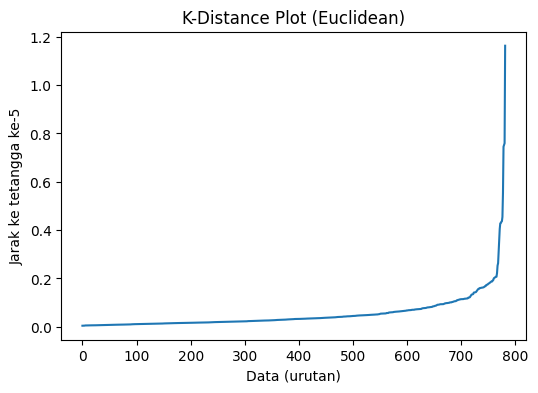

In [36]:
from sklearn.neighbors import NearestNeighbors

k = 5
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

k_distances = np.sort(distances[:,k-1])

plt.figure(figsize=(6,4))
plt.plot(k_distances)
plt.xlabel('Data (urutan)')
plt.ylabel(f'Jarak ke tetangga ke-{k}')
plt.title('K-Distance Plot (Euclidean)')
plt.show()

In [49]:
from sklearn.cluster import DBSCAN

eps = 0.2

dbscan = DBSCAN(
    eps=eps,
    min_samples=min_samples,
    metric='euclidean'
)

labels = dbscan.fit_predict(X_scaled)

In [38]:
df_clean['cluster'] = labels

In [39]:
df_clean['cluster'].value_counts()

,count
cluster,
0,491
2,147
3,48
1,45
5,17
4,16
-1,13
6,5


In [40]:
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = (labels == -1).sum()

print("Jumlah cluster:", n_clusters)
print("Jumlah noise:", n_noise)


Jumlah cluster: 7
Jumlah noise: 13


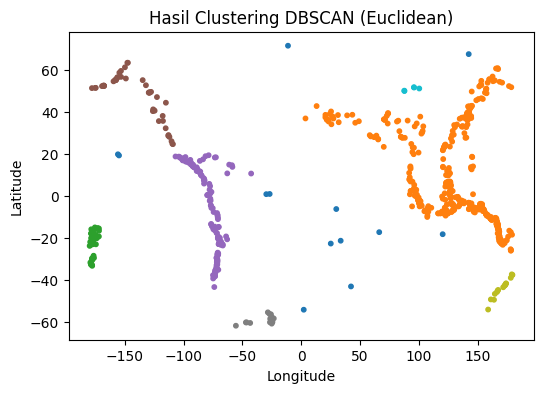

In [41]:
plt.figure(figsize=(6,4))
plt.scatter(
    df_clean['longitude'],
    df_clean['latitude'],
    c=df_clean['cluster'],
    cmap='tab10',
    s=10
)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Hasil Clustering DBSCAN (Euclidean)')
plt.show()


## 5. Visualiasi Peta

In [42]:
import folium

In [43]:
center_lat = df_clean['latitude'].mean()
center_lon = df_clean['longitude'].mean()

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=4
)

In [44]:
import matplotlib.colors as mcolors

color_list = list(mcolors.TABLEAU_COLORS.values())

df_clean['color'] = df_clean['cluster'].apply(
    lambda x: 'black' if x == -1 else color_list[x % len(color_list)]
)


In [46]:
for _, row in df_clean.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color=row['color'],
        fill=True,
        fill_opacity=0.6,
        popup=f"Cluster: {row['cluster']}"
    ).add_to(m)

In [47]:
m